In [27]:
# ==============================
# 1. Imports
# ==============================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from scipy import sparse
import xgboost as xgb
from xgboost import XGBClassifier

# ==============================
# 2. Load Data
# ==============================
train_df = pd.read_csv("Train_Dataset_(1)_(1).csv")
test_df = pd.read_csv("Test_Dataset_(1)_(1)_(1).csv")

# Replace with your actual target column name from train
target_col = "Attrition"

# ==============================
# 3. Drop missing target
# ==============================
train_df = train_df.dropna(subset=[target_col])

# Split features and target
X = train_df.drop(columns=[target_col])
y = train_df[target_col]

# Keep test features separately
X_test = test_df.copy()

# ==============================
# 4. Train-Validation Split
# ==============================
X_tr, X_va, y_tr, y_va = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ==============================
# 5. Identify column types
# ==============================
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

# ==============================
# 6. Preprocess Numerical
# ==============================
num_imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

X_tr_num = num_imputer.fit_transform(X_tr[num_cols])
X_va_num = num_imputer.transform(X_va[num_cols])
X_test_num = num_imputer.transform(X_test[num_cols])

X_tr_num = scaler.fit_transform(X_tr_num)
X_va_num = scaler.transform(X_va_num)
X_test_num = scaler.transform(X_test_num)

# ==============================
# 7. Preprocess Categorical
# ==============================
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)

if cat_cols:
    X_tr_cat = ohe.fit_transform(X_tr[cat_cols])
    X_va_cat = ohe.transform(X_va[cat_cols])
    X_test_cat = ohe.transform(X_test[cat_cols])
else:
    X_tr_cat = X_va_cat = X_test_cat = None

# ==============================
# 8. Combine Num + Cat
# ==============================
def combine(num, cat):
    if cat is not None:
        return sparse.hstack([num, cat])
    else:
        return num

X_tr_all = combine(X_tr_num, X_tr_cat)
X_va_all = combine(X_va_num, X_va_cat)
X_test_all = combine(X_test_num, X_test_cat)

print("Train shape:", X_tr_all.shape)
print("Validation shape:", X_va_all.shape)
print("Test shape:", X_test_all.shape)

# ==============================
# 9. Handle Class Imbalance
# ==============================
# Compute scale_pos_weight
pos = (y_tr == 1).sum()
neg = (y_tr == 0).sum()
scale_pos_weight = neg / pos
print("scale_pos_weight:", scale_pos_weight)

# ==============================
# 10. Train XGBoost
# ==============================
xgb_clf = XGBClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.0,
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    random_state=42,
    scale_pos_weight=scale_pos_weight
)

xgb_clf.fit(
    X_tr_all, y_tr,
    eval_set=[(X_va_all, y_va)],
    verbose=False,
)


# ==============================
# 11. Predictions
# ==============================
# Predict hard class labels
y_test_pred = xgb_clf.predict(X_test_all)

# ==============================
# 12. Create Submission
# ==============================
# Adjust "id" and "target" to your competition’s submission format

submission = pd.DataFrame({
    "EmployeeID": test_df["EmployeeID"],   # must match test file column
    "Attrition": y_test_pred               # must match competition target name
})

submission.to_csv("submission.csv", index=False,header=['EmployeeID','Attrition'])
print("✅ submission.csv saved!")
submission.head()


Train shape: (4144, 42)
Validation shape: (1036, 42)
Test shape: (2630, 42)
scale_pos_weight: 2.58477508650519
✅ submission.csv saved!


,EmployeeID,Attrition
0,6110001,1
1,6110002,0
2,6110003,0
3,6110004,1
4,6110005,0


In [23]:
print("Train rows:", train_df.shape[0])
print("Test rows:", test_df.shape[0])
print("Submission rows:", submission.shape[0])


Train rows: 5180
Test rows: 2630
Submission rows: 2630


In [11]:
# ==============================
# 10. Hyperparameter Tuning with XGBoost
# ==============================
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

# Define parameter grid for XGBoost
param_grid = {
    'n_estimators': [300, 500, 800, 1200],
    'max_depth': [3, 4, 5, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 2, 5],
    'min_child_weight': [1, 3, 5, 7]
}

# Initialize classifier
xgb_clf = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    use_label_encoder=False,
    random_state=42,
    scale_pos_weight=scale_pos_weight
)

# RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid,
    n_iter=40,               # number of parameter sets to try
    scoring='accuracy',      # use 'f1' if dataset is imbalanced
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit search
search.fit(X_tr_all, y_tr)

print("Best Parameters:", search.best_params_)
print("Best CV Score:", search.best_score_)

# Train final model with best params
best_xgb = search.best_estimator_
best_xgb.fit(X_tr_all, y_tr)

# Validate
y_val_pred = best_xgb.predict(X_va_all)
val_acc = accuracy_score(y_va, y_val_pred)
print("Validation Accuracy:", val_acc)

# ==============================
# 11. Predictions
# ==============================
# Predict hard class labels (0/1 only)
y_test_pred = best_xgb.predict(X_test_all)

# ==============================
# 12. Create Submission
# ==============================
submission = pd.DataFrame({
    "EmployeeID": test_df["EmployeeID"],   # must match test file column
    "Attrition": y_test_pred.astype(int)   # force integers 0/1
})

submission.to_csv("submission.csv", index=False, header=['EmployeeID','Attrition'])
print("✅ submission.csv saved!")
submission.head()


Fitting 3 folds for each of 40 candidates, totalling 120 fits


C:\Users\Sudhanshu\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:40:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters: {'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.6}
Best CV Score: 0.9592154639510161


C:\Users\Sudhanshu\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:40:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy: 0.9739382239382239
✅ submission.csv saved!


,EmployeeID,Attrition
0,6110001,1
1,6110002,0
2,6110003,0
3,6110004,1
4,6110005,0


In [9]:
# ==============================
# 1. Imports --- BEST
# ==============================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from scipy import sparse
from sklearn.metrics import accuracy_score
import xgboost as xgb
from xgboost import XGBClassifier

# ==============================
# 2. Load Data
# ==============================
train_df = pd.read_csv("Train_Dataset_(1)_(1).csv")
test_df = pd.read_csv("Test_Dataset_(1)_(1)_(1).csv")

target_col = "Attrition"

# ==============================
# 3. Drop missing target
# ==============================
train_df = train_df.dropna(subset=[target_col])

X = train_df.drop(columns=[target_col])
y = train_df[target_col]

X_test = test_df.copy()

# ==============================
# 4. Train-Validation Split
# ==============================
X_tr, X_va, y_tr, y_va = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ==============================
# 5. Identify column types
# ==============================
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

# ==============================
# 6. Preprocess Numerical
# ==============================
num_imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

X_tr_num = num_imputer.fit_transform(X_tr[num_cols])
X_va_num = num_imputer.transform(X_va[num_cols])
X_test_num = num_imputer.transform(X_test[num_cols])

X_tr_num = scaler.fit_transform(X_tr_num)
X_va_num = scaler.transform(X_va_num)
X_test_num = scaler.transform(X_test_num)

# ==============================
# 7. Preprocess Categorical
# ==============================
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)

if cat_cols:
    X_tr_cat = ohe.fit_transform(X_tr[cat_cols])
    X_va_cat = ohe.transform(X_va[cat_cols])
    X_test_cat = ohe.transform(X_test[cat_cols])
else:
    X_tr_cat = X_va_cat = X_test_cat = None

# ==============================
# 8. Combine Num + Cat
# ==============================
def combine(num, cat):
    if cat is not None:
        return sparse.hstack([num, cat])
    else:
        return num

X_tr_all = combine(X_tr_num, X_tr_cat)
X_va_all = combine(X_va_num, X_va_cat)
X_test_all = combine(X_test_num, X_test_cat)

print("Train shape:", X_tr_all.shape)
print("Validation shape:", X_va_all.shape)
print("Test shape:", X_test_all.shape)

# ==============================
# 9. Handle Class Imbalance
# ==============================
pos = (y_tr == 1).sum()
neg = (y_tr == 0).sum()
scale_pos_weight = neg / pos
print("scale_pos_weight:", scale_pos_weight)

# ==============================
# 10. Hyperparameter Tuning
# ==============================
xgb_clf = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False
)

param_dist = {
    "n_estimators": [ 800, 1000],
    "max_depth": [3, 4, 5, 6, 7, 8],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.4, 0.6, 0.8, 1.0],
    "colsample_bytree": [0.4, 0.6, 0.8, 1.0],
    "min_child_weight": [1, 3, 5, 7],
    "gamma": [0, 0.1, 0.2, 0.3, 0.5],
    "reg_lambda": [0.5, 1.0, 2.0],
    "reg_alpha": [0, 0.1, 0.5, 1.0]
}

rs = RandomizedSearchCV(
    xgb_clf,
    param_distributions=param_dist,
    n_iter=50,
    scoring="accuracy",
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

rs.fit(X_tr_all, y_tr)

print("Best Params:", rs.best_params_)
print("Best CV Score:", rs.best_score_)

best_model = rs.best_estimator_

# ==============================
# 11. Threshold Tuning
# ==============================
y_va_proba = best_model.predict_proba(X_va_all)[:, 1]

best_acc = 0
best_thresh = 0.5
for thresh in np.arange(0.3, 0.81, 0.01):
    preds = (y_va_proba >= thresh).astype(int)
    acc = accuracy_score(y_va, preds)
    if acc > best_acc:
        best_acc = acc
        best_thresh = thresh

print(f"Best Threshold: {best_thresh:.3f}, Validation Accuracy: {best_acc:.6f}")

# ==============================
# 12. Final Predictions
# ==============================
y_test_proba = best_model.predict_proba(X_test_all)[:, 1]
y_test_pred = (y_test_proba >= best_thresh).astype(int)

# ==============================
# 13. Submission
# ==============================
submission = pd.DataFrame({
    "EmployeeID": test_df["EmployeeID"],
    "Attrition": y_test_pred
})

submission.to_csv("submission.csv", index=False)
print("✅ submission.csv saved!")
submission.head()


Train shape: (4144, 42)
Validation shape: (1036, 42)
Test shape: (2630, 42)
scale_pos_weight: 2.58477508650519
Fitting 3 folds for each of 50 candidates, totalling 150 fits


C:\Users\Sudhanshu\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:37:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Params: {'subsample': 1.0, 'reg_lambda': 2.0, 'reg_alpha': 0, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.2, 'gamma': 0.3, 'colsample_bytree': 0.8}
Best CV Score: 0.9582513772293195
Best Threshold: 0.710, Validation Accuracy: 0.977799
✅ submission.csv saved!


,EmployeeID,Attrition
0,6110001,1
1,6110002,0
2,6110003,0
3,6110004,1
4,6110005,0


In [14]:
# ==============================
# 1. Imports
# ==============================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from scipy import sparse
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

# ==============================
# 2. Load Data
# ==============================
train_df = pd.read_csv("Train_Dataset_(1)_(1).csv")
test_df = pd.read_csv("Test_Dataset_(1)_(1)_(1).csv")

target_col = "Attrition"

# ==============================
# 3. Drop missing target
# ==============================
train_df = train_df.dropna(subset=[target_col])

X = train_df.drop(columns=[target_col])
y = train_df[target_col]

X_test = test_df.copy()

# ==============================
# 4. Train-Validation Split
# ==============================
X_tr, X_va, y_tr, y_va = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ==============================
# 5. Identify column types
# ==============================
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

# ==============================
# 6. Preprocess Numerical
# ==============================
num_imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

X_tr_num = num_imputer.fit_transform(X_tr[num_cols])
X_va_num = num_imputer.transform(X_va[num_cols])
X_test_num = num_imputer.transform(X_test[num_cols])

X_tr_num = scaler.fit_transform(X_tr_num)
X_va_num = scaler.transform(X_va_num)
X_test_num = scaler.transform(X_test_num)

# ==============================
# 7. Preprocess Categorical
# ==============================
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)

if cat_cols:
    X_tr_cat = ohe.fit_transform(X_tr[cat_cols])
    X_va_cat = ohe.transform(X_va[cat_cols])
    X_test_cat = ohe.transform(X_test[cat_cols])
else:
    X_tr_cat = X_va_cat = X_test_cat = None

# ==============================
# 8. Combine Num + Cat
# ==============================
def combine(num, cat):
    if cat is not None:
        return sparse.hstack([num, cat])
    else:
        return num

X_tr_all = combine(X_tr_num, X_tr_cat)
X_va_all = combine(X_va_num, X_va_cat)
X_test_all = combine(X_test_num, X_test_cat)

print("Train shape:", X_tr_all.shape)
print("Validation shape:", X_va_all.shape)
print("Test shape:", X_test_all.shape)

# ==============================
# 9. Handle Class Imbalance
# ==============================
pos = (y_tr == 1).sum()
neg = (y_tr == 0).sum()
scale_pos_weight = neg / pos
print("scale_pos_weight:", scale_pos_weight)

# ==============================
# 10. Hyperparameter Tuning (XGBoost)
# ==============================
xgb_clf = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False
)

param_dist = {
    "n_estimators": [800, 1000, 1500],
    "max_depth": [6, 8, 10, 12],
    "learning_rate": [0.01, 0.03, 0.05],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "min_child_weight": [1, 3, 5],
    "gamma": [0, 0.1, 0.2, 0.3],
    "reg_lambda": [0.5, 1.0, 2.0],
    "reg_alpha": [0, 0.1, 0.5, 1.0]
}

rs = RandomizedSearchCV(
    xgb_clf,
    param_distributions=param_dist,
    n_iter=60,   # wider search
    scoring="accuracy",
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

rs.fit(X_tr_all, y_tr)

print("Best Params:", rs.best_params_)
print("Best CV Score:", rs.best_score_)

best_model = rs.best_estimator_

# ==============================
# 11. Threshold Tuning
# ==============================
y_va_proba = best_model.predict_proba(X_va_all)[:, 1]

best_acc = 0
best_thresh = 0.5
for thresh in np.arange(0.3, 0.81, 0.01):
    preds = (y_va_proba >= thresh).astype(int)
    acc = accuracy_score(y_va, preds)
    if acc > best_acc:
        best_acc = acc
        best_thresh = thresh

print(f"Best Threshold: {best_thresh:.3f}, Validation Accuracy: {best_acc:.6f}")

# ==============================
# 12. Final Predictions
# ==============================
y_test_proba = best_model.predict_proba(X_test_all)[:, 1]
y_test_pred = (y_test_proba >= best_thresh).astype(int)

# ==============================
# 13. Submission
# ==============================
submission = pd.DataFrame({
    "EmployeeID": test_df["EmployeeID"],
    "Attrition": y_test_pred
})

submission.to_csv("submission.csv", index=False)
print("✅ submission.csv saved!")
submission.head()


Train shape: (4144, 42)
Validation shape: (1036, 42)
Test shape: (2630, 42)
scale_pos_weight: 2.58477508650519
Fitting 3 folds for each of 60 candidates, totalling 180 fits


C:\Users\Sudhanshu\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:53:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Params: {'subsample': 1.0, 'reg_lambda': 2.0, 'reg_alpha': 0, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 12, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.6}
Best CV Score: 0.9596997778059553
Best Threshold: 0.760, Validation Accuracy: 0.983591
✅ submission.csv saved!


,EmployeeID,Attrition
0,6110001,1
1,6110002,0
2,6110003,0
3,6110004,1
4,6110005,0


Train shape: (7810, 22)
Test shape: (2630, 21)
Columns: ['EmployeeID', 'Attrition', 'Age', 'TravelProfile', 'Department', 'HomeToWork', 'EducationField', 'Gender', 'HourlnWeek', 'Involvement', 'WorkLifeBalance', 'Designation', 'JobSatisfaction', 'ESOPs', 'NumCompaniesWorked', 'OverTime', 'SalaryHikelastYear', 'WorkExperience', 'LastPromotion', 'CurrentProfile', 'MaritalStatus', 'MonthlyIncome']

Target distribution:
Attrition
0.0    3735
NaN    2630
1.0    1445
Name: count, dtype: int64


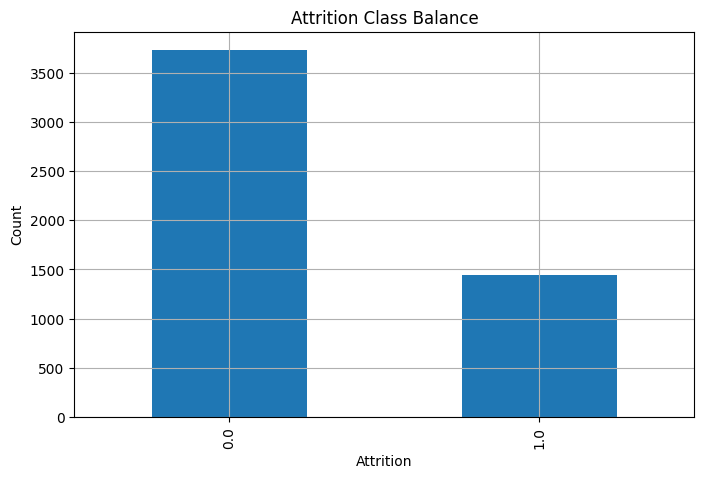


Missing values (train):
Age                   2946
CurrentProfile        2941
HourlnWeek            2917
HomeToWork            2885
WorkExperience        2817
SalaryHikelastYear    2799
Department            2754
MonthlyIncome         2723
LastPromotion         2700
Gender                2676
Designation           2668
TravelProfile         2630
EmployeeID            2630
Attrition             2630
ESOPs                 2630
JobSatisfaction       2630
WorkLifeBalance       2630
Involvement           2630
EducationField        2630
OverTime              2630
dtype: int64

Missing values (test):
Age                   142
HourlnWeek            136
CurrentProfile        134
HomeToWork            126
WorkExperience        122
SalaryHikelastYear     94
Department             58
LastPromotion          57
MonthlyIncome          33
Designation            30
Gender                 30
TravelProfile           0
EmployeeID              0
ESOPs                   0
JobSatisfaction         0
WorkLife

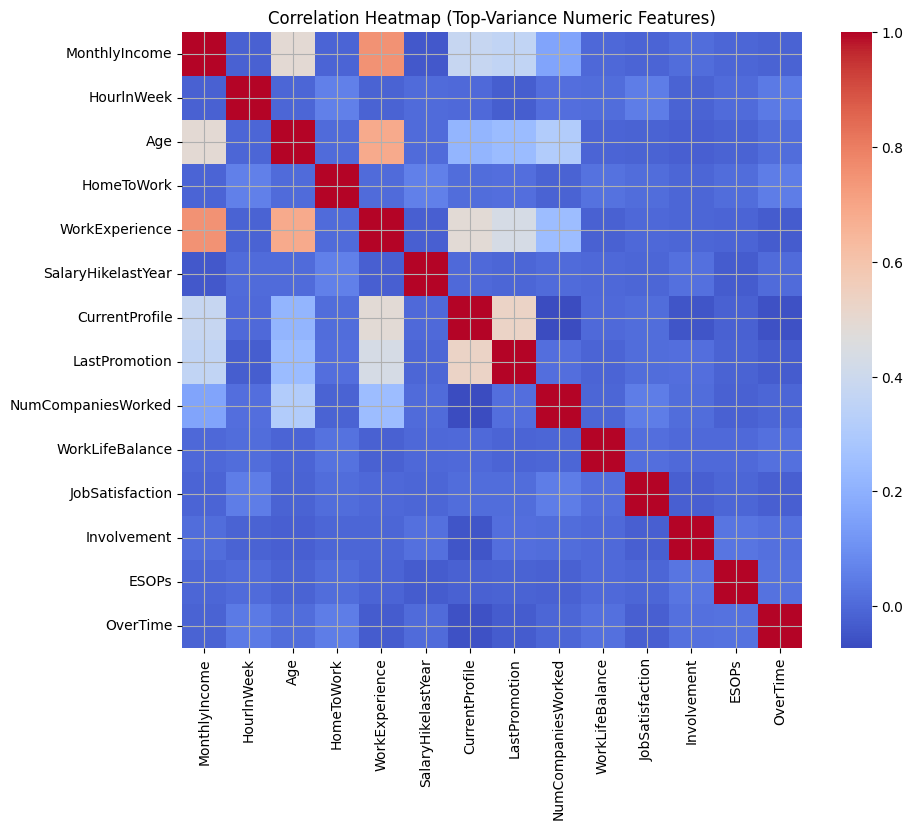


Attrition rate by 'TravelProfile':
TravelProfile
Yes       0.389153
Rarely    0.263954
No        0.154472
Name: Attrition, dtype: float64


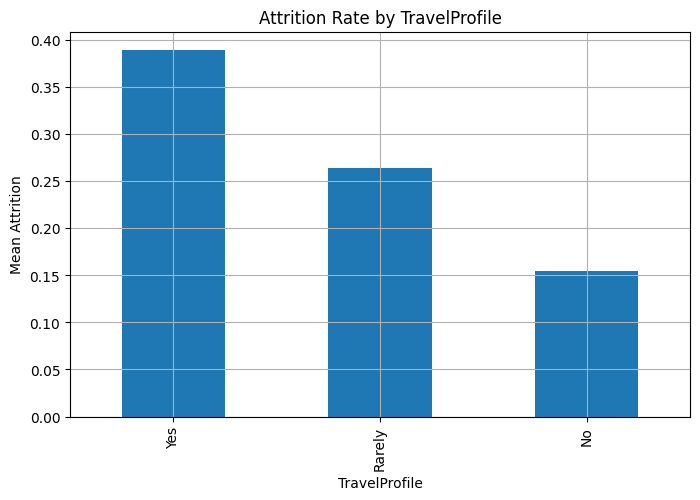


Attrition rate by 'Department':
Department
Sales        0.331269
Marketing    0.301802
Analytics    0.238894
Name: Attrition, dtype: float64


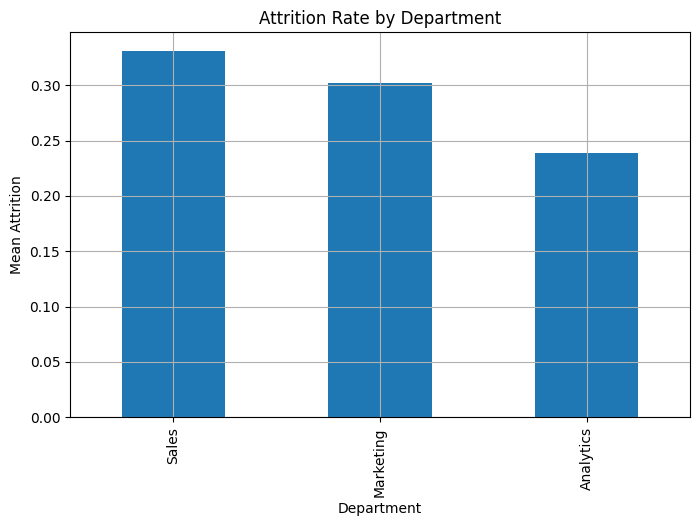


Attrition rate by 'EducationField':
EducationField
Engineer             0.404517
MBA                  0.384615
Marketing Diploma    0.366501
Statistics           0.253171
CA                   0.242949
Other                0.225352
Name: Attrition, dtype: float64


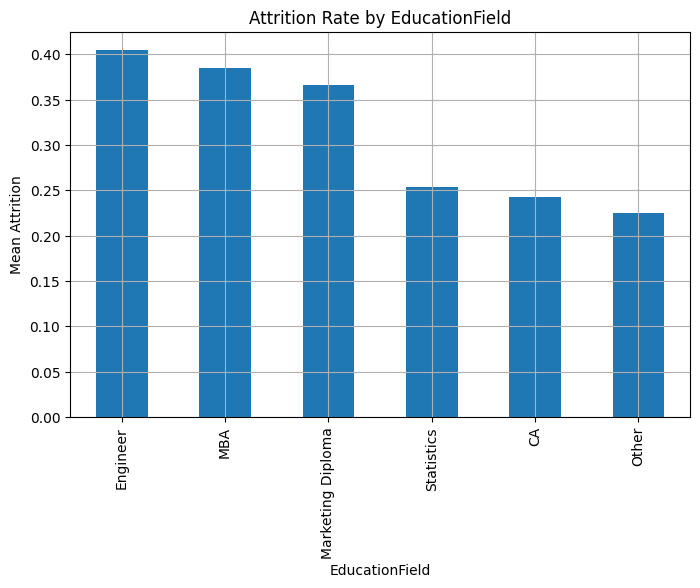


Attrition rate by 'Gender':
Gender
Female    0.301196
Male      0.292178
F         0.158120
Name: Attrition, dtype: float64


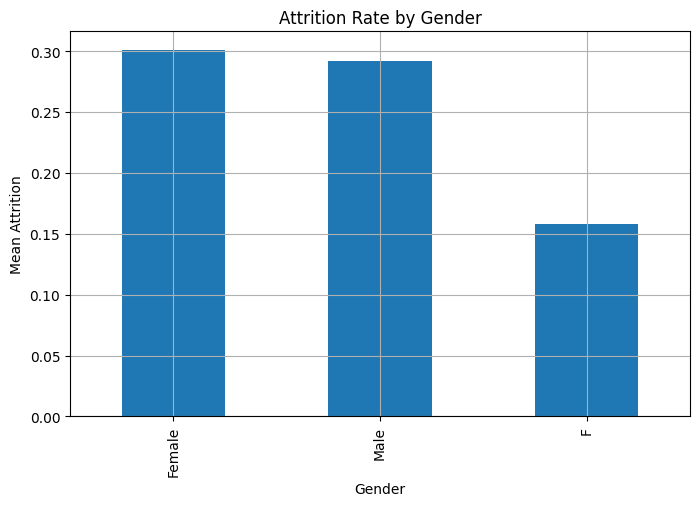


Attrition rate by 'Designation':
Designation
Executive         0.410714
Senior Manager    0.243775
Manager           0.190205
VP                0.125561
AVP               0.079268
Name: Attrition, dtype: float64


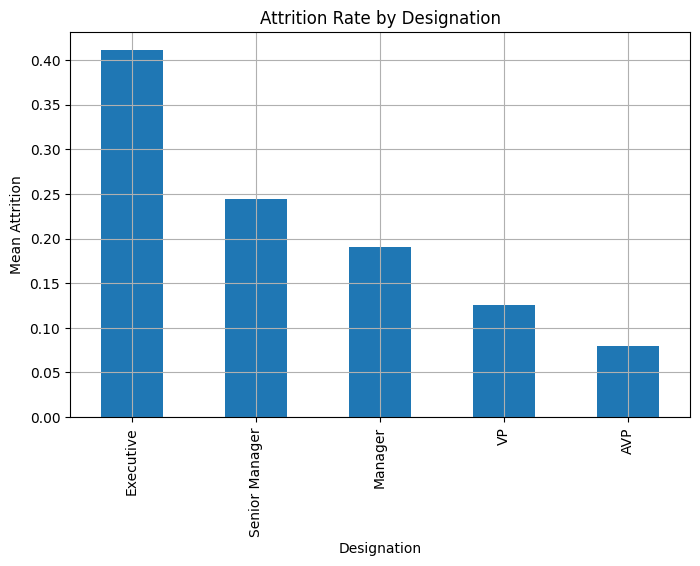


Attrition rate by 'MaritalStatus':
MaritalStatus
Single      0.414977
M           0.315245
Divorsed    0.229331
Married     0.143123
Name: Attrition, dtype: float64


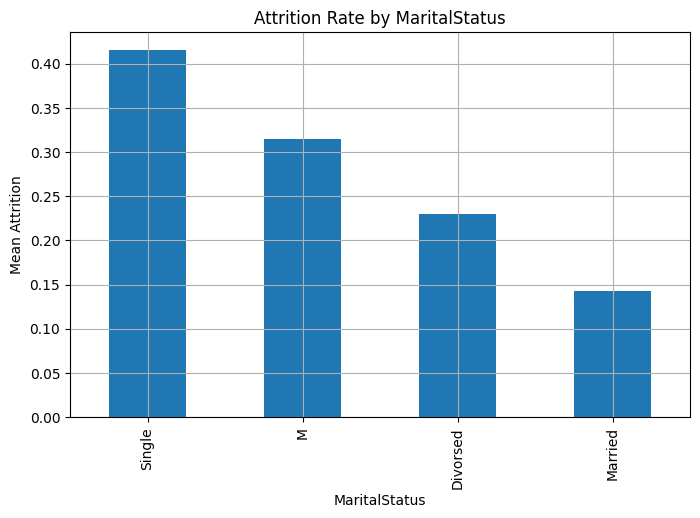


Detected numeric columns: ['Age', 'HomeToWork', 'HourlnWeek', 'Involvement', 'WorkLifeBalance', 'JobSatisfaction', 'ESOPs', 'NumCompaniesWorked', 'OverTime', 'SalaryHikelastYear', 'WorkExperience', 'LastPromotion', 'CurrentProfile', 'MonthlyIncome']
Detected categorical columns: ['TravelProfile', 'Department', 'EducationField', 'Gender', 'Designation', 'MaritalStatus']

Final feature matrices:
Train: (4144, 41) Validation: (1036, 41) Test: (2630, 41)
scale_pos_weight: 2.58477508650519
Fitting 3 folds for each of 60 candidates, totalling 180 fits

Best Params: {'subsample': 1.0, 'reg_lambda': 1.0, 'reg_alpha': 0, 'n_estimators': 800, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.8}
Best CV Accuracy: 0.9635608403343144

=== Validation @ 0.5 threshold ===
Accuracy : 0.975869
Precision: 0.952055
Recall   : 0.961938
F1-score : 0.956971
Confusion matrix:
 [[733  14]
 [ 11 278]]
ROC-AUC  : 0.997526

Best Accuracy threshold: 0.740 -> Acc=0.9

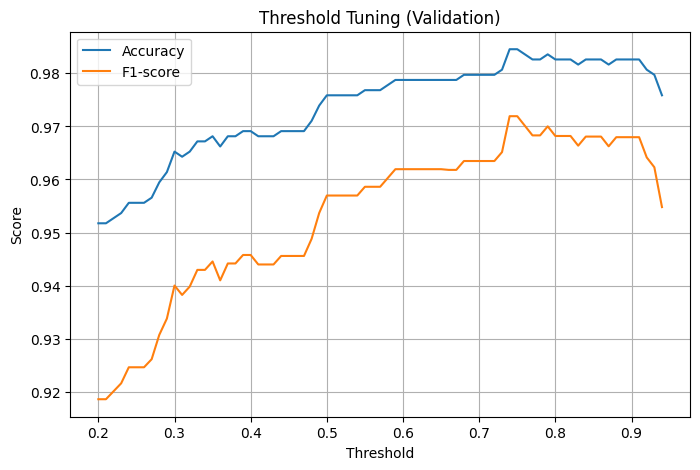


=== Validation @ best-Accuracy threshold (0.740) ===
Accuracy : 0.984556
Precision: 0.985765
Recall   : 0.958478
F1-score : 0.971930
Confusion matrix:
 [[743   4]
 [ 12 277]]
ROC-AUC  : 0.997526

=== Validation @ best-F1 threshold (0.740) ===
Accuracy : 0.984556
Precision: 0.985765
Recall   : 0.958478
F1-score : 0.971930
Confusion matrix:
 [[743   4]
 [ 12 277]]
ROC-AUC  : 0.997526

Top 25 features by importance:
                             feature  importance
39             MaritalStatus_Married    0.087711
8                           OverTime    0.087009
23                EducationField_MBA    0.058398
30                        Gender_nan    0.053947
32             Designation_Executive    0.050262
35                    Designation_VP    0.042391
31                   Designation_AVP    0.032874
18              Department_Marketing    0.032754
40              MaritalStatus_Single    0.029888
27                          Gender_F    0.028836
19                  Department_Sales    0.0

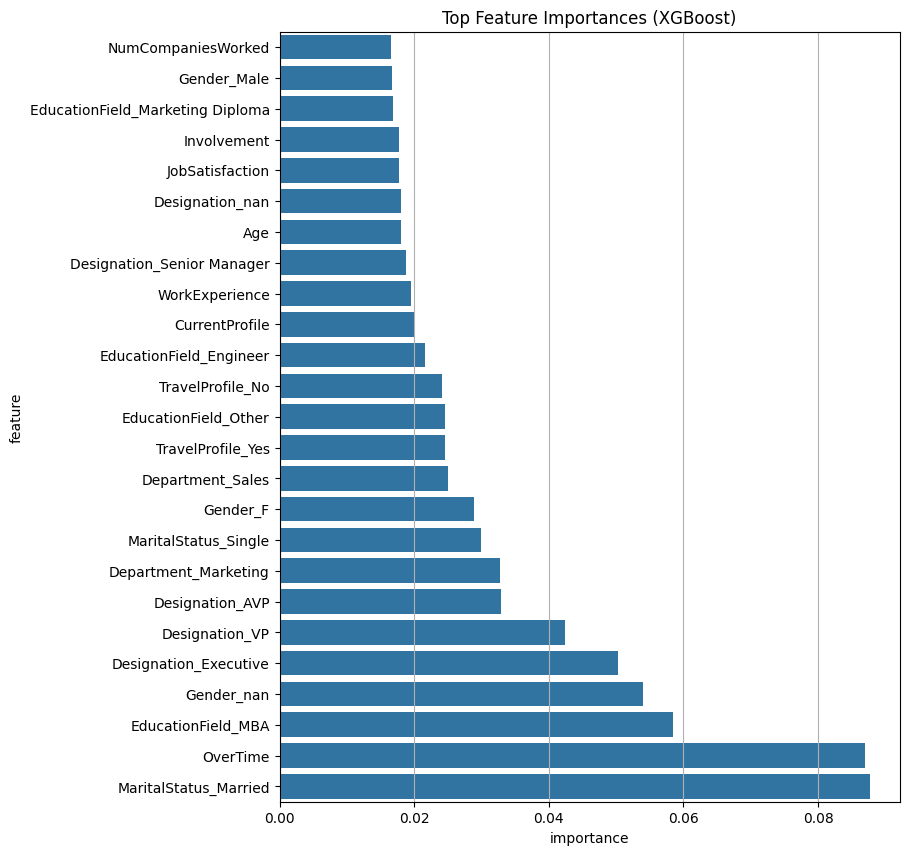


✅ submission.csv saved!
   EmployeeID  Attrition
0     6110001          1
1     6110002          0
2     6110003          0
3     6110004          1
4     6110005          0


In [ ]:
## Different attempt/ Best new (0.99)

# ============================================
# Employee Attrition Prediction - Full XGBoost
# EDA + Preprocessing + Tuning + Metrics + Submit
# ============================================

# 1) Imports
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, classification_report
)
from scipy import sparse

from xgboost import XGBClassifier

# Set matplotlib defaults
plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams["axes.grid"] = True

# 2) Load data
train_path = "Train_Dataset_(1)_(1).csv"
test_path  = "Test_Dataset_(1)_(1)_(1).csv"

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

target_col = "Attrition"
id_col     = "EmployeeID"

print("Train shape:", train_df.shape)
print("Test shape:",  test_df.shape)
print("Columns:", list(train_df.columns))

# 3) Basic sanity checks
assert target_col in train_df.columns, f"Target '{target_col}' not in train columns."
assert id_col in train_df.columns,     f"ID '{id_col}' not in train columns."
assert id_col in test_df.columns,      f"ID '{id_col}' not in test columns."

# 4) EDA ---------------------------------------------------------
# 4.1 Target distribution
print("\nTarget distribution:")
print(train_df[target_col].value_counts(dropna=False))

fig, ax = plt.subplots()
train_df[target_col].value_counts().plot(kind="bar", ax=ax)
ax.set_title("Attrition Class Balance")
ax.set_xlabel("Attrition")
ax.set_ylabel("Count")
plt.show()

# 4.2 Missing values
print("\nMissing values (train):")
print(train_df.isna().sum().sort_values(ascending=False).head(20))

print("\nMissing values (test):")
print(test_df.isna().sum().sort_values(ascending=False).head(20))

# 4.3 Numeric correlation heatmap (top 15 by variance)
num_cols_all = train_df.select_dtypes(include=[np.number]).columns.tolist()
num_cols_all = [c for c in num_cols_all if c not in [id_col, target_col]]
if len(num_cols_all) > 1:
    corr = train_df[num_cols_all].corr()
    # choose top 15 columns by variance to keep the heatmap readable
    var_rank = train_df[num_cols_all].var().sort_values(ascending=False).head(15).index
    fig, ax = plt.subplots(figsize=(10,8))
    sns.heatmap(corr.loc[var_rank, var_rank], cmap="coolwarm", annot=False, ax=ax)
    ax.set_title("Correlation Heatmap (Top-Variance Numeric Features)")
    plt.show()

# 4.4 Categorical attrition rates (top 6 categories)
cat_cols_all = train_df.select_dtypes(exclude=[np.number]).columns.tolist()
cat_cols_all = [c for c in cat_cols_all if c not in [target_col]]
for c in cat_cols_all[:6]:  # limit print/plots
    if train_df[c].nunique() <= 20:
        rate = train_df.groupby(c)[target_col].mean().sort_values(ascending=False)
        print(f"\nAttrition rate by '{c}':")
        print(rate)
        fig, ax = plt.subplots()
        rate.plot(kind="bar", ax=ax)
        ax.set_title(f"Attrition Rate by {c}")
        ax.set_ylabel("Mean Attrition")
        plt.show()

# 5) Prepare data ------------------------------------------------
# Drop rows with missing target
train_df = train_df.dropna(subset=[target_col]).copy()

# Split features / target
X = train_df.drop(columns=[target_col])
y = train_df[target_col].astype(int)

# Keep an untouched copy of test features
X_test_raw = test_df.copy()

# Split train/validation for model selection
X_tr_raw, X_va_raw, y_tr, y_va = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Identify column types
num_cols = X_tr_raw.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_tr_raw.select_dtypes(exclude=[np.number]).columns.tolist()

# Remove ID column from features if present
if id_col in num_cols: num_cols.remove(id_col)
if id_col in cat_cols: cat_cols.remove(id_col)

print("\nDetected numeric columns:", num_cols)
print("Detected categorical columns:", cat_cols)

# 6) Preprocessing -----------------------------------------------
# Numerical: median impute + scale
num_imputer = SimpleImputer(strategy="median")
scaler      = StandardScaler()

X_tr_num   = num_imputer.fit_transform(X_tr_raw[num_cols]) if len(num_cols) > 0 else None
X_va_num   = num_imputer.transform(X_va_raw[num_cols])      if len(num_cols) > 0 else None
X_test_num = num_imputer.transform(X_test_raw[num_cols])    if len(num_cols) > 0 else None

if X_tr_num is not None:
    X_tr_num   = scaler.fit_transform(X_tr_num)
    X_va_num   = scaler.transform(X_va_num)
    X_test_num = scaler.transform(X_test_num)

# Categorical: OneHotEncoder
# NOTE: newer sklearn uses 'sparse_output=True'. If your sklearn is older, switch to OneHotEncoder(sparse=True)
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
except TypeError:
    # fallback for older sklearn versions
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=True)

if len(cat_cols) > 0:
    X_tr_cat   = ohe.fit_transform(X_tr_raw[cat_cols])
    X_va_cat   = ohe.transform(X_va_raw[cat_cols])
    X_test_cat = ohe.transform(X_test_raw[cat_cols])
    ohe_feat_names = ohe.get_feature_names_out(cat_cols)
else:
    X_tr_cat = X_va_cat = X_test_cat = None
    ohe_feat_names = np.array([])

# Combine
def combine(num, cat):
    if (num is not None) and (cat is not None):
        return sparse.hstack([num, cat]).tocsr()
    elif num is not None:
        return sparse.csr_matrix(num)
    else:
        return cat.tocsr()

X_tr_all   = combine(X_tr_num, X_tr_cat)
X_va_all   = combine(X_va_num, X_va_cat)
X_test_all = combine(X_test_num, X_test_cat)

print("\nFinal feature matrices:")
print("Train:", X_tr_all.shape, "Validation:", X_va_all.shape, "Test:", X_test_all.shape)

# Build feature names for importance plotting
num_feat_names = np.array(num_cols)
all_feat_names = np.concatenate([num_feat_names, ohe_feat_names])

# 7) Class imbalance handling ------------------------------------
pos = (y_tr == 1).sum()
neg = (y_tr == 0).sum()
scale_pos_weight = (neg / pos) if pos > 0 else 1.0
print("scale_pos_weight:", scale_pos_weight)

# 8) Hyperparameter tuning (RandomizedSearchCV) ------------------
base_xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    random_state=42,
    scale_pos_weight=scale_pos_weight,
)

param_dist = {
    "n_estimators": [500, 800, 1000, 1500],
    "max_depth": [3, 4, 5, 6, 7, 8],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "min_child_weight": [1, 2, 3, 5],
    "gamma": [0, 0.1, 0.2, 0.3],
    "reg_lambda": [0.5, 1.0, 2.0],
    "reg_alpha": [0, 0.1, 0.5, 1.0],
}

rs = RandomizedSearchCV(
    estimator=base_xgb,
    param_distributions=param_dist,
    n_iter=60,                 # adjust if you want faster/slower
    scoring="accuracy",
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

rs.fit(X_tr_all, y_tr)
print("\nBest Params:", rs.best_params_)
print("Best CV Accuracy:", rs.best_score_)

best_model = rs.best_estimator_

# 9) Validation performance (default threshold 0.5) --------------
y_va_proba = best_model.predict_proba(X_va_all)[:, 1]
y_va_pred_05 = (y_va_proba >= 0.5).astype(int)

def print_metrics(y_true, y_pred, proba=None, label="Metrics"):
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    print(f"\n=== {label} ===")
    print(f"Accuracy : {acc:.6f}")
    print(f"Precision: {prec:.6f}")
    print(f"Recall   : {rec:.6f}")
    print(f"F1-score : {f1:.6f}")
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
    if proba is not None:
        try:
            auc = roc_auc_score(y_true, proba)
            print(f"ROC-AUC  : {auc:.6f}")
        except:
            pass

print_metrics(y_va, y_va_pred_05, proba=y_va_proba, label="Validation @ 0.5 threshold")

# 10) Threshold tuning (maximize Accuracy & F1) -------------------
ths = np.arange(0.20, 0.95, 0.01)

best_acc, best_acc_th = -1, 0.5
best_f1,  best_f1_th  = -1, 0.5

acc_track, f1_track = [], []

for t in ths:
    preds = (y_va_proba >= t).astype(int)
    a = accuracy_score(y_va, preds)
    f = f1_score(y_va, preds, zero_division=0)
    acc_track.append(a)
    f1_track.append(f)
    if a > best_acc:
        best_acc = a
        best_acc_th = t
    if f > best_f1:
        best_f1 = f
        best_f1_th = t

print(f"\nBest Accuracy threshold: {best_acc_th:.3f} -> Acc={best_acc:.6f}")
print(f"Best F1 threshold      : {best_f1_th:.3f} -> F1 ={best_f1:.6f}")

# Plot threshold vs metrics
fig, ax = plt.subplots()
ax.plot(ths, acc_track, label="Accuracy")
ax.plot(ths, f1_track, label="F1-score")
ax.set_xlabel("Threshold")
ax.set_ylabel("Score")
ax.set_title("Threshold Tuning (Validation)")
ax.legend()
plt.show()

# Evaluate at both tuned thresholds
y_va_pred_best_acc = (y_va_proba >= best_acc_th).astype(int)
y_va_pred_best_f1  = (y_va_proba >= best_f1_th).astype(int)

print_metrics(y_va, y_va_pred_best_acc, proba=y_va_proba, label=f"Validation @ best-Accuracy threshold ({best_acc_th:.3f})")
print_metrics(y_va, y_va_pred_best_f1,  proba=y_va_proba, label=f"Validation @ best-F1 threshold ({best_f1_th:.3f})")

# 11) Feature importance -----------------------------------------
# Map importances back to feature names
importances = getattr(best_model, "feature_importances_", None)

if importances is not None and len(importances) == X_tr_all.shape[1]:
    fi = pd.DataFrame({
        "feature": all_feat_names,
        "importance": importances
    }).sort_values("importance", ascending=False)

    print("\nTop 25 features by importance:")
    print(fi.head(25))

    topN = min(25, fi.shape[0])
    fig, ax = plt.subplots(figsize=(8, 10))
    sns.barplot(data=fi.head(topN)[::-1], x="importance", y="feature", ax=ax)
    ax.set_title("Top Feature Importances (XGBoost)")
    plt.show()
else:
    print("\n(feature_importances_ not available or length mismatch; skipping importance plot)")

# 12) Train on full training data + Final predictions -------------
# Use the threshold that maximized validation Accuracy for submission (per your metric)
final_thresh = best_acc_th

# Refit the best model on ALL available labeled data (train_df)
# Rebuild the preprocessing on full train to avoid leakage from val only
X_full_raw = train_df.drop(columns=[target_col])
y_full     = train_df[target_col].astype(int)

# Recompute preprocessing on full data
num_cols_full = X_full_raw.select_dtypes(include=[np.number]).columns.tolist()
cat_cols_full = X_full_raw.select_dtypes(exclude=[np.number]).columns.tolist()
if id_col in num_cols_full: num_cols_full.remove(id_col)
if id_col in cat_cols_full: cat_cols_full.remove(id_col)

num_imputer_full = SimpleImputer(strategy="median")
scaler_full      = StandardScaler()

X_full_num   = num_imputer_full.fit_transform(X_full_raw[num_cols_full]) if len(num_cols_full)>0 else None
X_test_num   = num_imputer_full.transform(X_test_raw[num_cols_full])     if len(num_cols_full)>0 else None

if X_full_num is not None:
    X_full_num = scaler_full.fit_transform(X_full_num)
    X_test_num = scaler_full.transform(X_test_num)

try:
    ohe_full = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
except TypeError:
    ohe_full = OneHotEncoder(handle_unknown="ignore", sparse=True)

if len(cat_cols_full) > 0:
    X_full_cat = ohe_full.fit_transform(X_full_raw[cat_cols_full])
    X_test_cat = ohe_full.transform(X_test_raw[cat_cols_full])
else:
    X_full_cat = X_test_cat = None

def combine2(num, cat):
    if (num is not None) and (cat is not None):
        return sparse.hstack([num, cat]).tocsr()
    elif num is not None:
        return sparse.csr_matrix(num)
    else:
        return cat.tocsr()

X_full_all = combine2(X_full_num, X_full_cat)
X_test_all = combine2(X_test_num, X_test_cat)

# Recreate best model with same hyperparameters
final_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    **rs.best_params_
)
final_model.fit(X_full_all, y_full)

# Predict test
test_proba = final_model.predict_proba(X_test_all)[:, 1]
test_pred  = (test_proba >= final_thresh).astype(int)

# 13) Submission --------------------------------------------------
submission = pd.DataFrame({
    "EmployeeID": test_df[id_col],
    "Attrition": test_pred
})
submission.to_csv("submission.csv", index=False)
print("\n✅ submission.csv saved!")
print(submission.head())
